# Logisitic Regression and Support Vector Machines Minilab

You are to perform predictive analysis (classification) upon a data set: model the dataset using methods we have discussed in class: logistic regression and support vector machines, and making conclusions from the analysis. Follow the CRISP-DM framework in your analysis (you are not performing all of the CRISP-DM outline, only the portions relevant to the grading rubric outlined below). This report is worth 10% of the final grade. You may complete this assignment in teams of as many as three people.  




By Martin Garcia, Joanna Duran, Daniel Byrne

## Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random
import time

from sklearn.linear_model import SGDClassifier
from sklearn import svm

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Business Understanding

Our objective is to create a logistic regression model and a support vector machine model for the classification of each image. We will determine which is a better model based on prediction accuracy, training time, and efficiency.The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6,000 images per class. 

Our objective is to create a logistic regression model and a support vector machine model for the classification of each image in our test set. We will determine which model is best suited for this standard classification task based on a comparison on their prediction accuracy, training times, and computational efficiency.

## Data Meaning Type

### The CIFAR-10 dataset

We are using the [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset which consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. The dataset includes are 50000(80%) training images and 10000(20%) test images broken in to 5 pre-randomized training batches and 1 test batch.

Each training batch contains 10,000 observations with a row vector of length 3072 representative of color image of 32x32 pixels. The first 1024 columns consist of red values, followed by green, and blue. The data also incorporates labels ranging from 0 to 9 and are listed below.

* airplane : 0
* automobile : 1
* bird : 2
* cat : 3
* deer : 4
* dog : 5
* frog : 6
* horse : 7
* ship : 8
* truck : 9

The test batch contains 1000 randomly-selected images from each class. The 5 training batches are randomized and contain a variable number of images from each class. 

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

## Simple Statistics

In [2]:
#load the data, reshape to 32x32 matrix per color, transpose matrices
def load_cfar10_batch(path, batch_id = None, reshape = True):
    """
    Argument:
    path -- path the datasets
    batch_id -- id of the batch (1 to 5) to load
    
    Returns:
    parameters -- python dictionary containing:
                    X -- features
                    Y -- labels
    """
    if batch_id is not None:
        filepath = path + 'data_batch_' + str(batch_id)
    else:
        filepath = path
        
    with open(filepath, mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
    
    if reshape:    
        X = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
        Y = np.array(batch['labels'])
    else:
        X = batch['data']
        Y = np.array(batch['labels'])
        
    return X, Y


Stats of batch #5:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 1014
Label Counts of [1](AUTOMOBILE) : 1014
Label Counts of [2](BIRD) : 952
Label Counts of [3](CAT) : 1016
Label Counts of [4](DEER) : 997
Label Counts of [5](DOG) : 1025
Label Counts of [6](FROG) : 980
Label Counts of [7](HORSE) : 977
Label Counts of [8](SHIP) : 1003
Label Counts of [9](TRUCK) : 1022

Example of Image 7385:
Image - Min Value: 14 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 4 Name: deer


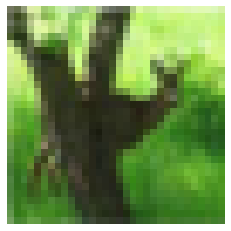

In [3]:
#load labels for our label
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#display images
def display_stats(data, batch_id, sample_id):
    features, labels = load_cfar10_batch(data, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))

    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)

batch_id = random.randint(1,5)
sample_id = random.randint(1,10000)
display_stats( "data/", batch_id, sample_id)

## Models

In this section we will create a logistic regression model and a support vector machine model for the classification task involved with your dataset.  We will assess how well each model performs (use 80/20 training/testing split)and adjust parameters of the models to make them more accurate. 

### Logistic Regression Model

In [5]:
# Build Logistic Regression Model with Stochastic Gradient Descent 
X,Y = load_cfar10_batch("data/",1,False)

for n in range(2,6):
    x,y = load_cfar10_batch("data/",n,False)    
    X = np.concatenate((X,x),axis=0)
    Y = np.concatenate((Y,y),axis=0)

test_X,test_Y = load_cfar10_batch("data/test_batch",None,False)

# Modify the dataset labels to lable cats/not/cats
#(if_test_is_false, if_test_is_true)[test]
catY = (Y == 3)
cat_test_Y = (test_Y == 3) 

sgdlr = SGDClassifier(alpha=0.001, max_iter=5000, tol=1e-3,verbose=1,n_jobs=4,loss="log")

print("Data shape: ",X.shape)
print("Labels shape: ",catY.shape)

print("Test Data shape: ",test_X.shape)
print("Test Labels shape: ",cat_test_Y.shape)


NameError: name 'load_cfar10_batch' is not defined

In [5]:
import time

start = time.time()
sgdlr.fit(X,catY)
end = time.time()
elapsed = end - start
print("Training complete.  Time elapsed = ",elapsed)
score = sgdlr.score(test_X,cat_test_Y)
print(score)

-- Epoch 1
Norm: 2018.84, NNZs: 3072, Bias: 0.064965, T: 50000, Avg. loss: 507470.791631
Total training time: 0.59 seconds.
-- Epoch 2
Norm: 1220.10, NNZs: 3072, Bias: -1.267551, T: 100000, Avg. loss: 62270.502011
Total training time: 1.17 seconds.
-- Epoch 3
Norm: 992.93, NNZs: 3072, Bias: -1.494646, T: 150000, Avg. loss: 36327.886524
Total training time: 1.73 seconds.
-- Epoch 4
Norm: 853.06, NNZs: 3072, Bias: -1.835954, T: 200000, Avg. loss: 25671.264961
Total training time: 2.26 seconds.
-- Epoch 5
Norm: 757.05, NNZs: 3072, Bias: -2.207628, T: 250000, Avg. loss: 19740.677890
Total training time: 2.76 seconds.
-- Epoch 6
Norm: 688.67, NNZs: 3072, Bias: -2.382126, T: 300000, Avg. loss: 16265.010577
Total training time: 3.25 seconds.
-- Epoch 7
Norm: 634.71, NNZs: 3072, Bias: -2.523195, T: 350000, Avg. loss: 13774.281827
Total training time: 3.75 seconds.
-- Epoch 8
Norm: 593.13, NNZs: 3072, Bias: -2.736521, T: 400000, Avg. loss: 11900.781147
Total training time: 4.30 seconds.
-- Epoc

Norm: 203.40, NNZs: 3072, Bias: -5.705853, T: 3350000, Avg. loss: 1311.940582
Total training time: 34.36 seconds.
-- Epoch 68
Norm: 202.08, NNZs: 3072, Bias: -5.724229, T: 3400000, Avg. loss: 1294.785113
Total training time: 34.89 seconds.
-- Epoch 69
Norm: 200.37, NNZs: 3072, Bias: -5.742522, T: 3450000, Avg. loss: 1257.700250
Total training time: 35.42 seconds.
-- Epoch 70
Norm: 198.98, NNZs: 3072, Bias: -5.761492, T: 3500000, Avg. loss: 1267.077569
Total training time: 35.94 seconds.
-- Epoch 71
Norm: 197.62, NNZs: 3072, Bias: -5.786739, T: 3550000, Avg. loss: 1229.279308
Total training time: 36.45 seconds.
-- Epoch 72
Norm: 195.87, NNZs: 3072, Bias: -5.813641, T: 3600000, Avg. loss: 1231.762128
Total training time: 36.97 seconds.
-- Epoch 73
Norm: 194.76, NNZs: 3072, Bias: -5.835760, T: 3650000, Avg. loss: 1192.681846
Total training time: 37.48 seconds.
-- Epoch 74
Norm: 193.49, NNZs: 3072, Bias: -5.859623, T: 3700000, Avg. loss: 1189.557965
Total training time: 37.98 seconds.
-- E

Norm: 144.38, NNZs: 3072, Bias: -6.802567, T: 6650000, Avg. loss: 649.414302
Total training time: 68.83 seconds.
-- Epoch 134
Norm: 143.84, NNZs: 3072, Bias: -6.815466, T: 6700000, Avg. loss: 642.483690
Total training time: 69.36 seconds.
-- Epoch 135
Norm: 143.20, NNZs: 3072, Bias: -6.831417, T: 6750000, Avg. loss: 646.352750
Total training time: 69.89 seconds.
-- Epoch 136
Norm: 142.72, NNZs: 3072, Bias: -6.843199, T: 6800000, Avg. loss: 640.075664
Total training time: 70.42 seconds.
-- Epoch 137
Norm: 142.15, NNZs: 3072, Bias: -6.856613, T: 6850000, Avg. loss: 633.337286
Total training time: 70.95 seconds.
-- Epoch 138
Norm: 141.66, NNZs: 3072, Bias: -6.865318, T: 6900000, Avg. loss: 620.699287
Total training time: 71.47 seconds.
-- Epoch 139
Norm: 141.12, NNZs: 3072, Bias: -6.873768, T: 6950000, Avg. loss: 625.642632
Total training time: 71.99 seconds.
-- Epoch 140
Norm: 140.56, NNZs: 3072, Bias: -6.886896, T: 7000000, Avg. loss: 619.337698
Total training time: 72.52 seconds.
-- Ep

Norm: 118.76, NNZs: 3072, Bias: -7.430109, T: 9900000, Avg. loss: 441.515043
Total training time: 103.45 seconds.
-- Epoch 199
Norm: 118.42, NNZs: 3072, Bias: -7.436361, T: 9950000, Avg. loss: 438.961092
Total training time: 103.98 seconds.
-- Epoch 200
Norm: 118.13, NNZs: 3072, Bias: -7.441816, T: 10000000, Avg. loss: 435.074266
Total training time: 104.52 seconds.
-- Epoch 201
Norm: 117.81, NNZs: 3072, Bias: -7.448676, T: 10050000, Avg. loss: 435.224811
Total training time: 105.05 seconds.
-- Epoch 202
Norm: 117.61, NNZs: 3072, Bias: -7.455966, T: 10100000, Avg. loss: 428.304398
Total training time: 105.61 seconds.
-- Epoch 203
Norm: 117.26, NNZs: 3072, Bias: -7.463353, T: 10150000, Avg. loss: 431.167915
Total training time: 106.14 seconds.
-- Epoch 204
Norm: 116.97, NNZs: 3072, Bias: -7.469130, T: 10200000, Avg. loss: 423.107761
Total training time: 106.70 seconds.
-- Epoch 205
Norm: 116.62, NNZs: 3072, Bias: -7.478141, T: 10250000, Avg. loss: 423.309094
Total training time: 107.24 

Norm: 103.02, NNZs: 3072, Bias: -7.889597, T: 13150000, Avg. loss: 323.374164
Total training time: 139.13 seconds.
-- Epoch 264
Norm: 102.85, NNZs: 3072, Bias: -7.895978, T: 13200000, Avg. loss: 323.533132
Total training time: 139.70 seconds.
-- Epoch 265
Norm: 102.59, NNZs: 3072, Bias: -7.901511, T: 13250000, Avg. loss: 326.240842
Total training time: 140.27 seconds.
-- Epoch 266
Norm: 102.44, NNZs: 3072, Bias: -7.906618, T: 13300000, Avg. loss: 321.132094
Total training time: 140.83 seconds.
-- Epoch 267
Norm: 102.22, NNZs: 3072, Bias: -7.910571, T: 13350000, Avg. loss: 321.666004
Total training time: 141.39 seconds.
-- Epoch 268
Norm: 102.05, NNZs: 3072, Bias: -7.916671, T: 13400000, Avg. loss: 315.782378
Total training time: 141.94 seconds.
-- Epoch 269
Norm: 101.83, NNZs: 3072, Bias: -7.924458, T: 13450000, Avg. loss: 319.215612
Total training time: 142.49 seconds.
-- Epoch 270
Norm: 101.58, NNZs: 3072, Bias: -7.930174, T: 13500000, Avg. loss: 322.953098
Total training time: 143.0

In [6]:

from sklearn.utils import compute_class_weight



### Support Vector Machine Model

In [7]:
# Build SVM Regression Model with Stochastic Gradient Descent 
sgd_svm = SGDClassifier(alpha=0.001, max_iter=5000, verbose = 1, tol=1e-3,n_jobs=4)

In [8]:
start = time.time()
sgd_svm.fit(X,catY)
end = time.time()

svm_elapsed = end - start
print("Training complete.  Time elapsed = ",svm_elapsed)

score = sgdlr.score(test_X,cat_test_Y)
print(score)

-- Epoch 1
Norm: 2042.73, NNZs: 3072, Bias: -2.250817, T: 50000, Avg. loss: 491046.067882
Total training time: 0.50 seconds.
-- Epoch 2
Norm: 1294.92, NNZs: 3072, Bias: -3.132942, T: 100000, Avg. loss: 61769.509924
Total training time: 0.99 seconds.
-- Epoch 3
Norm: 984.08, NNZs: 3072, Bias: -3.533658, T: 150000, Avg. loss: 36577.268502
Total training time: 1.49 seconds.
-- Epoch 4
Norm: 871.42, NNZs: 3072, Bias: -3.951988, T: 200000, Avg. loss: 25590.029044
Total training time: 1.98 seconds.
-- Epoch 5
Norm: 744.98, NNZs: 3072, Bias: -4.272601, T: 250000, Avg. loss: 20066.518284
Total training time: 2.47 seconds.
-- Epoch 6
Norm: 672.47, NNZs: 3072, Bias: -4.464752, T: 300000, Avg. loss: 16135.275324
Total training time: 2.96 seconds.
-- Epoch 7
Norm: 620.57, NNZs: 3072, Bias: -4.664368, T: 350000, Avg. loss: 13662.617055
Total training time: 3.45 seconds.
-- Epoch 8
Norm: 581.23, NNZs: 3072, Bias: -4.904084, T: 400000, Avg. loss: 11872.875461
Total training time: 3.95 seconds.
-- Epo

Norm: 204.16, NNZs: 3072, Bias: -7.887179, T: 3350000, Avg. loss: 1312.570122
Total training time: 32.84 seconds.
-- Epoch 68
Norm: 202.60, NNZs: 3072, Bias: -7.899042, T: 3400000, Avg. loss: 1284.454659
Total training time: 33.40 seconds.
-- Epoch 69
Norm: 201.07, NNZs: 3072, Bias: -7.921529, T: 3450000, Avg. loss: 1273.012116
Total training time: 33.90 seconds.
-- Epoch 70
Norm: 199.68, NNZs: 3072, Bias: -7.947365, T: 3500000, Avg. loss: 1254.976624
Total training time: 34.38 seconds.
-- Epoch 71
Norm: 198.66, NNZs: 3072, Bias: -7.965831, T: 3550000, Avg. loss: 1233.465443
Total training time: 34.87 seconds.
-- Epoch 72
Norm: 197.13, NNZs: 3072, Bias: -7.979814, T: 3600000, Avg. loss: 1209.782124
Total training time: 35.38 seconds.
-- Epoch 73
Norm: 195.88, NNZs: 3072, Bias: -8.000501, T: 3650000, Avg. loss: 1196.193440
Total training time: 35.87 seconds.
-- Epoch 74
Norm: 193.98, NNZs: 3072, Bias: -8.026070, T: 3700000, Avg. loss: 1190.758386
Total training time: 36.35 seconds.
-- E

Norm: 145.41, NNZs: 3072, Bias: -8.930374, T: 6650000, Avg. loss: 653.860612
Total training time: 65.07 seconds.
-- Epoch 134
Norm: 144.68, NNZs: 3072, Bias: -8.940266, T: 6700000, Avg. loss: 653.418209
Total training time: 65.57 seconds.
-- Epoch 135
Norm: 144.34, NNZs: 3072, Bias: -8.952163, T: 6750000, Avg. loss: 645.357815
Total training time: 66.05 seconds.
-- Epoch 136
Norm: 143.64, NNZs: 3072, Bias: -8.966487, T: 6800000, Avg. loss: 636.412176
Total training time: 66.54 seconds.
-- Epoch 137
Norm: 143.20, NNZs: 3072, Bias: -8.981425, T: 6850000, Avg. loss: 629.620145
Total training time: 67.02 seconds.
-- Epoch 138
Norm: 142.72, NNZs: 3072, Bias: -8.992476, T: 6900000, Avg. loss: 634.429225
Total training time: 67.51 seconds.
-- Epoch 139
Norm: 142.15, NNZs: 3072, Bias: -9.004170, T: 6950000, Avg. loss: 627.826151
Total training time: 67.99 seconds.
-- Epoch 140
Norm: 141.74, NNZs: 3072, Bias: -9.013788, T: 7000000, Avg. loss: 614.516937
Total training time: 68.48 seconds.
-- Ep

Norm: 118.82, NNZs: 3072, Bias: -9.555604, T: 9950000, Avg. loss: 432.487791
Total training time: 97.38 seconds.
-- Epoch 200
Norm: 118.51, NNZs: 3072, Bias: -9.562319, T: 10000000, Avg. loss: 434.307095
Total training time: 97.87 seconds.
-- Epoch 201
Norm: 118.29, NNZs: 3072, Bias: -9.569998, T: 10050000, Avg. loss: 428.762714
Total training time: 98.37 seconds.
-- Epoch 202
Norm: 118.03, NNZs: 3072, Bias: -9.580621, T: 10100000, Avg. loss: 426.740976
Total training time: 98.87 seconds.
-- Epoch 203
Norm: 117.77, NNZs: 3072, Bias: -9.590399, T: 10150000, Avg. loss: 419.356384
Total training time: 99.35 seconds.
-- Epoch 204
Norm: 117.58, NNZs: 3072, Bias: -9.598951, T: 10200000, Avg. loss: 420.926780
Total training time: 99.86 seconds.
-- Epoch 205
Norm: 117.30, NNZs: 3072, Bias: -9.605014, T: 10250000, Avg. loss: 421.303107
Total training time: 100.36 seconds.
-- Epoch 206
Norm: 116.96, NNZs: 3072, Bias: -9.613377, T: 10300000, Avg. loss: 420.905525
Total training time: 100.85 secon

Norm: 102.89, NNZs: 3072, Bias: -10.025692, T: 13200000, Avg. loss: 327.585287
Total training time: 129.25 seconds.
-- Epoch 265
Norm: 102.69, NNZs: 3072, Bias: -10.031588, T: 13250000, Avg. loss: 322.642221
Total training time: 129.75 seconds.
-- Epoch 266
Norm: 102.50, NNZs: 3072, Bias: -10.037089, T: 13300000, Avg. loss: 323.468895
Total training time: 130.24 seconds.
-- Epoch 267
Norm: 102.34, NNZs: 3072, Bias: -10.042941, T: 13350000, Avg. loss: 322.707864
Total training time: 130.74 seconds.
-- Epoch 268
Norm: 102.18, NNZs: 3072, Bias: -10.050567, T: 13400000, Avg. loss: 319.342204
Total training time: 131.23 seconds.
-- Epoch 269
Norm: 101.96, NNZs: 3072, Bias: -10.057268, T: 13450000, Avg. loss: 316.905319
Total training time: 131.73 seconds.
-- Epoch 270
Norm: 101.74, NNZs: 3072, Bias: -10.064465, T: 13500000, Avg. loss: 318.478618
Total training time: 132.20 seconds.
-- Epoch 271
Norm: 101.57, NNZs: 3072, Bias: -10.070602, T: 13550000, Avg. loss: 315.978226
Total training tim

Norm: 92.00, NNZs: 3072, Bias: -10.381642, T: 16400000, Avg. loss: 265.389730
Total training time: 160.97 seconds.
-- Epoch 329
Norm: 91.89, NNZs: 3072, Bias: -10.387305, T: 16450000, Avg. loss: 258.691570
Total training time: 161.45 seconds.
-- Epoch 330
Norm: 91.77, NNZs: 3072, Bias: -10.392585, T: 16500000, Avg. loss: 260.804968
Total training time: 161.99 seconds.
-- Epoch 331
Norm: 91.61, NNZs: 3072, Bias: -10.397609, T: 16550000, Avg. loss: 259.255589
Total training time: 162.57 seconds.
-- Epoch 332
Norm: 91.49, NNZs: 3072, Bias: -10.402134, T: 16600000, Avg. loss: 260.035362
Total training time: 163.07 seconds.
-- Epoch 333
Norm: 91.37, NNZs: 3072, Bias: -10.407066, T: 16650000, Avg. loss: 259.093561
Total training time: 163.59 seconds.
-- Epoch 334
Norm: 91.17, NNZs: 3072, Bias: -10.413182, T: 16700000, Avg. loss: 257.745829
Total training time: 164.07 seconds.
-- Epoch 335
Norm: 91.07, NNZs: 3072, Bias: -10.419938, T: 16750000, Avg. loss: 254.883191
Total training time: 164.5

In [9]:
#Weights
weights = sgd_svm.coef_
weights

array([[ 0.66753379,  0.10823427,  2.04356356, ...,  0.93763819,
        -0.42186767,  2.90590835]])

## Model Evaluations

In this section we will discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

In [3]:

def print_mislabeled_images(X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = y == p
    mislabeled_indices = np.asarray(np.where(a == False))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(10):
        index = mislabeled_indices[0][i]
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[index].reshape(3, 32, 32).transpose(1,2,0), interpolation='nearest')
        plt.axis('off')


In [4]:
pred_test = sgdlr.predict(test_X)
print_mislabeled_images(test_X,cat_test_Y,pred_test)

NameError: name 'sgdlr' is not defined

### Interpreting Feature Importance

In this section we will use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

### Interpreting Support Vectors

In this section we will look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.